# A Naive LSTM
* input size = 1
* hidden size = 10
* output size = 1
* mini-batch size = 24

## 1. construct the data set

In [1]:
import pandas as pd
import numpy as np

In [2]:
# load data of 39 buildings
df = pd.read_csv('../39个芝加哥办公楼14年6789月.csv')
building_names = df.columns[1:]
load = []
for name in building_names:
    load.append(df[name].values)
load = np.array(load)

# choose one building
data_ori = load[0]

# use max-min normalizaion
maxval = np.max(data_ori)
minval = np.min(data_ori)
data_nor = list(map(lambda x: (x - minval) / (maxval - minval), data_ori))

In [3]:
# parameters:
ifs = 1   # input feature size = 1
hfs = 10  # hidden feature size = 10
pfs = 1   # predict feature size = 1
mbs = 24   # mini batch size = 24 (a day)

In [4]:
def naive_dataset(ratio=0.7):
    data_X = data_nor[:-1]
    data_Y = data_nor[1:]
    
    train_size = int(len(data_X) * ratio)
    train_r = train_size - (train_size % mbs)
    
    test_size = len(data_X) - train_r
    test_r = test_size - (test_size % mbs) + train_r
    
    train_X = data_X[: train_r]
    train_Y = data_Y[: train_r]
    test_X = data_X[train_r : test_r]
    test_Y = data_Y[train_r : test_r]
    
    return [
        np.array(train_X).astype(np.float32),
        np.array(train_Y).astype(np.float32),
        np.array(test_X).astype(np.float32), 
        np.array(test_Y).astype(np.float32)
    ]

In [5]:
[train_X, train_Y, test_X, test_Y] = naive_dataset(0.7)

## 2. define the LSTM model

In [6]:
import torch
import torch.autograd as autograd
import torch.nn as nn
from torch.autograd import Variable

In [7]:
class lstm(nn.Module):
    def __init__(self, input_size=1, hidden_size=10, output_size=1, num_layer=1):
        super(lstm, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layer)
        self.hidden = self.init_hidden()
        self.hidden2pred = nn.Linear(hidden_size, output_size) 
        
    def init_hidden(self):
        h0 = autograd.Variable(torch.zeros(1, mbs, self.hidden_size)).cuda()
        c0 = autograd.Variable(torch.zeros(1, mbs, self.hidden_size)).cuda()
        return (h0, c0)
        
    def forward(self, x):
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        x, y, z = lstm_out.size()
        output = self.hidden2pred(lstm_out.view(x * y, z))
        return output.view(x, y, -1)

In [8]:
model = lstm().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [9]:
train_x = torch.from_numpy(train_X).view(-1, mbs, 1).cuda()
train_y = torch.from_numpy(train_Y).view(-1, mbs, 1).cuda()
test_x = torch.from_numpy(test_X).view(-1, mbs, 1).cuda()
test_y = torch.from_numpy(test_Y).view(-1, mbs, 1).cuda()

In [10]:
%%time
for e in range(500):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    
    out = model(var_x)
    loss = criterion(out, var_y)

    optimizer.zero_grad()
    loss.backward(retain_graph=True)
    optimizer.step()
    
    if (e + 1) % 50 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 50, Loss: 0.02182
Epoch: 100, Loss: 0.01241
Epoch: 150, Loss: 0.00980
Epoch: 200, Loss: 0.00975
Epoch: 250, Loss: 0.00970
Epoch: 300, Loss: 0.00966
Epoch: 350, Loss: 0.00962
Epoch: 400, Loss: 0.00962
Epoch: 450, Loss: 0.00959
Epoch: 500, Loss: 0.00955
Wall time: 3min 21s


## 3. evaluation of this model under this ratio

In [2]:
import matplotlib.pyplot as plt

In [12]:
model = model.eval()
pred_tensor = model(Variable(test_x))
pred_test = pred_tensor.view(-1).cpu()

In [13]:
pred = pred_test.detach().numpy()
real = test_y.view(-1).cpu().detach().numpy()

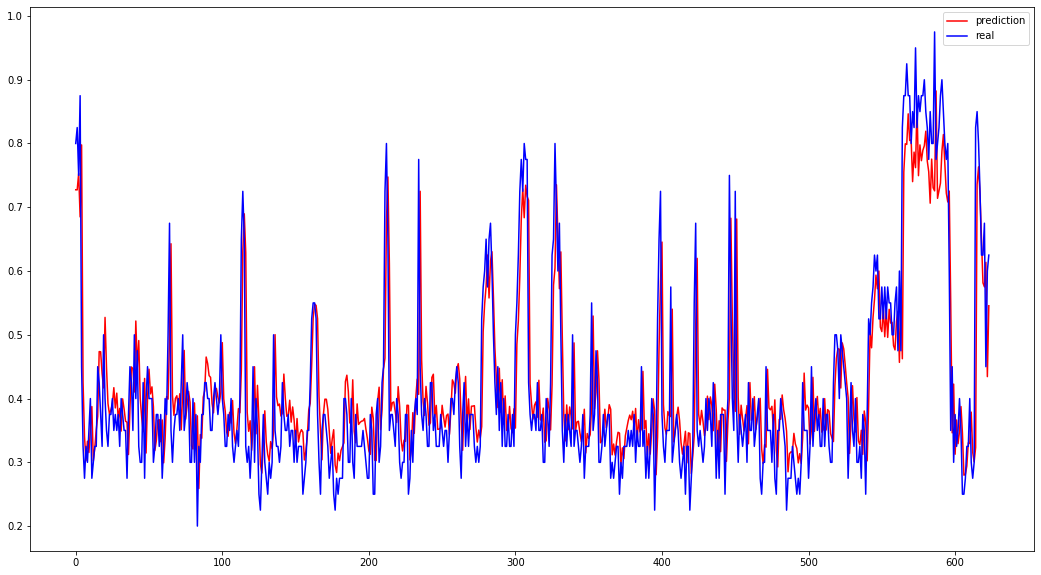

In [14]:
plt.figure(figsize=(18, 10))
plt.plot(pred, 'r', label='prediction')
plt.plot(real, 'b', label='real')
plt.legend(loc='best')

In [15]:
diff = []
for i in range(len(real)):
    diff.append((real[i] - pred[i])**2)
print(sum(diff) / len(diff))

0.007639644856176555


## 4. evaluation of this model

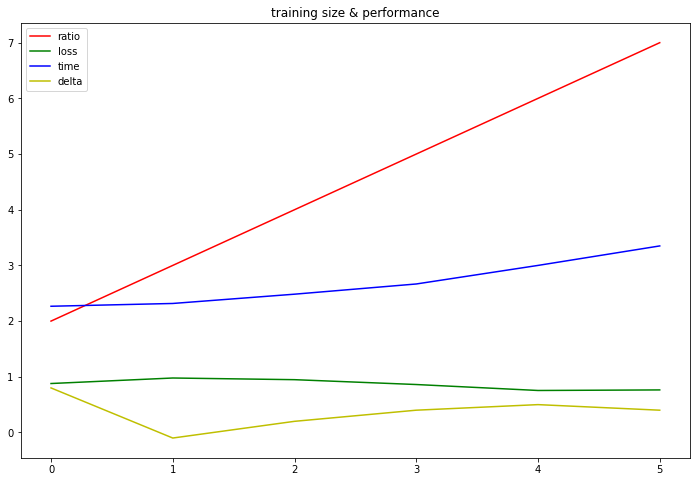

In [3]:
ratio = [0.2 * 10, 0.3 * 10, 0.4 * 10, 0.5 * 10, 0.6 * 10, 0.7 * 10]
loss = [0.00879 * 100, 0.00978 * 100, 0.00948 * 100, 0.00861 * 100, 0.00754 * 100, 0.00764 * 100]
time = [136/60, 139/60, 149/60, 160/60, 180/60, 201/60]
delta = [0.00008 * 10000, -0.00001 * 10000, 0.00002 * 10000, 0.00004 * 10000, 0.00005 * 10000, 0.00004 * 10000]

plt.figure(figsize=(12, 8))
plt.title('training size & performance')
plt.plot(ratio, 'r', label='ratio')
plt.plot(loss, 'g', label='loss')
plt.plot(time, 'b', label='time')
plt.plot(delta, 'y', label='delta')
plt.legend(loc='best')